# Reconstrution Network

In [1]:
# autoreload after code has changed
%load_ext autoreload
%autoreload 2

In [2]:
import os

# move into the correct dirrectory, e.g. move up one directory level iif this cell is run for the first time
try:
    a = first_time
except NameError:
    print("Running first time, moving up one dir level")
    os.chdir('..')  # Move up one directory level to the root directory of project
    first_time = False

print("This path should be the root directory of the project: ", os.getcwd())
    


Running first time, moving up one dir level
This path should be the root directory of the project:  /home/daniel/Documents/TUM/ADLR/tum-adlr-02


#### Import Libraries

In [25]:
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import datetime

import time



#### Project Imports

In [4]:
from data.model_classes import Mug, Bottle
from data.dataconverter import DataConverter
from data.reconstruction_dataset import *
from models.unet import UNet1


### Dataset
Creating the dataset object and applzing transformations to the data.

In [5]:
# Outcommented because there are currently someproblems running it in the notebook

# generate data
dataconverter = DataConverter(
    classes=[Mug(),Bottle()],
    min_order = 59,
    tact_order = 60
)
# set regenerate to true, if you run this after changes in dataconverter have been made
dataconverter.generate_2d_dataset(show_results=False, regenerate=False)


class mug already downloaedd. Skipping download.
class bottle already downloaedd. Skipping download.
2D images for classmug already exist. Skipping conversion.
2D images for classbottle already exist. Skipping conversion.


In [6]:
csv_file = './datasets/2D_shapes/annotations.csv'
root_dir = './datasets/2D_shapes'
composed = transforms.Compose([RandomOrientation(),
                               ToTensor()])

dataset = ReconstructionDataset(csv_file=csv_file,
                                root_dir=root_dir,
                                transform=composed)

Examplary data pairs:

<Figure size 640x480 with 0 Axes>

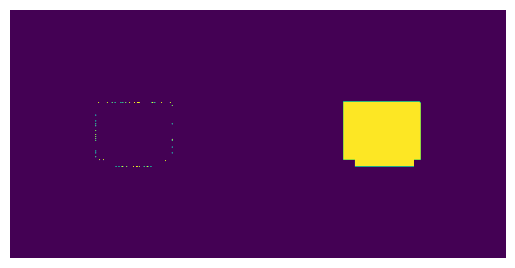

In [7]:
example_data = dataset[0]

plt.figure()
show_datapair(example_data['image'], example_data['label'])
plt.show()

#### Split Dataset into train, validation and test dataset

In [8]:
# Define the sizes for train, validation, and test
train_size = int(0.75 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


### Hyperparamters

In [21]:
batch_size = 16
learning_rate = 1e-4

### Dataloader
Creating a dataloader based on the dataset for batch processing.

TODO: Remove spacing in figure.

torch.Size([16, 1, 256, 256])
torch.Size([1, 256, 256])


<Figure size 1x19096 with 0 Axes>

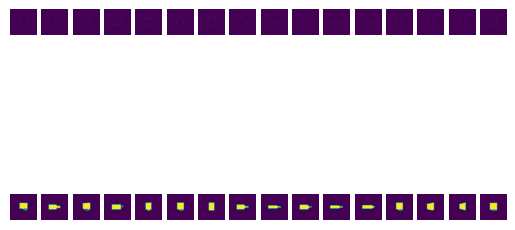

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)



batch = next(iter(train_loader))
print(batch['image'].shape)

show_datapair_batch(next(iter(train_loader)))


### Initialize Network

In [22]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet1().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


print(device)

cuda


### Training

Epoch [1/50], Step [100/668], Train Loss: 0.5747


<Figure size 640x480 with 0 Axes>

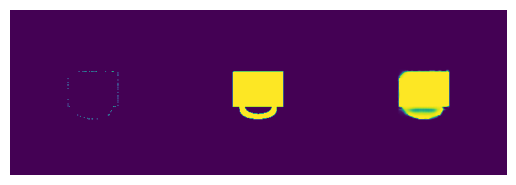

Epoch [1/50], Step [200/668], Train Loss: 0.5747


<Figure size 640x480 with 0 Axes>

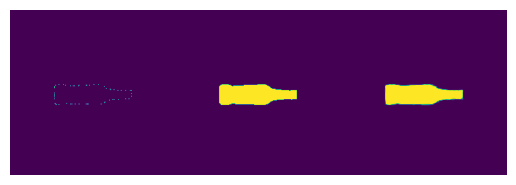

Epoch [1/50], Step [300/668], Train Loss: 0.5747


<Figure size 640x480 with 0 Axes>

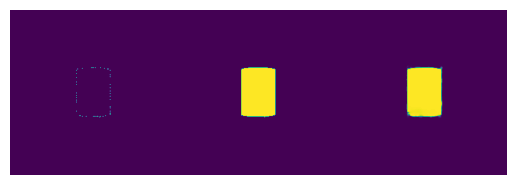

Epoch [1/50], Step [400/668], Train Loss: 0.5747


<Figure size 640x480 with 0 Axes>

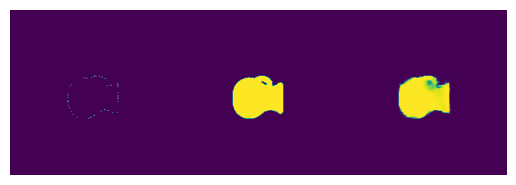

Epoch [1/50], Step [500/668], Train Loss: 0.5747


<Figure size 640x480 with 0 Axes>

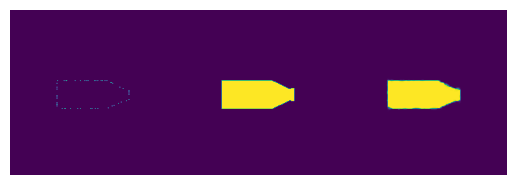

Epoch [1/50], Step [600/668], Train Loss: 0.5747


<Figure size 640x480 with 0 Axes>

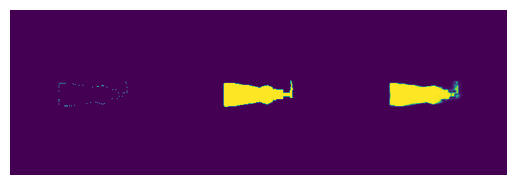

##########################################################################################
Epoch [1/50], Step [667/668], Val Loss: 0.0042 Val time prop: 0.0689
##########################################################################################
Epoch [2/50], Step [100/668], Train Loss: 0.0042


<Figure size 640x480 with 0 Axes>

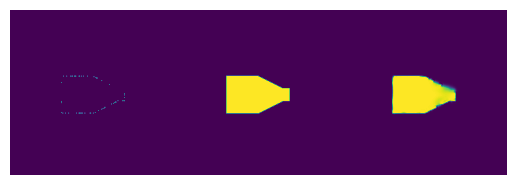

In [ ]:

# Set up TensorBoard
writer = SummaryWriter(f'runs/U-Net_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}')


# Training loop
num_epochs = 50
log_train_period = 100
log_val_period = len(train_loader)-1

# used to meassure proportion of time for calculation for val loss
train_period_stime_val = time.time()
# used to meassure proportion of time for adding images to writer
train_period_stime_train = time.time()



for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for i, batch in enumerate(train_loader):
        # todo change datatypes in dataset not in dataloader, use proper datatypes, output should be segmentation
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        if i % log_train_period == log_train_period-1:  # Log train loss and images every log_train_period batches


            train_duration = time.time() - train_period_stime_train
            
            log_starttime = time.time()
            
        
            # log training loss
            writer.add_scalar('Loss/train', running_train_loss / log_train_period, epoch * len(train_loader) + i)
            

            # Log one reconstructed training image sample
            img_grid = vutils.make_grid([inputs[-1], labels[-1], outputs[-1]])
            writer.add_image('reconstructed_training_images', img_grid, global_step=epoch * len(train_loader) + i)


            # Log one reconstructed validation image sample
            batch = next(iter(train_loader))
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            
            img_grid = vutils.make_grid([inputs[-1], labels[-1], outputs[-1]])
            writer.add_image('reconstructed_validation_images', img_grid, global_step=epoch * len(train_loader) + i)

            # ploting images like this (they are also plotted on tensorboard, but here they are more uebersichtlich somehow)
            plt.figure()
            show_datatripple(inputs[-1].cpu().detach().numpy(), labels[-1].cpu().detach().numpy(), outputs[-1].cpu().detach().numpy())
            plt.show()


            log_duration = tim.time() - log_starttime()
            log_prop = log_duration / train_duration
            train_period_stime_train = time.time()
            print(f'Epoch [{epoch+1 }/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {running_train_loss/log_train_period:.4f}',
                 f'log proportion{log_prop:.4f}')
            running_train_loss = 0.0

        
            
        if i % log_val_period == log_val_period-1:  # Log val loss every log_val_period batches

            train_duration = time.time() - train_period_stime_val
            
            val_starttime = time.time()
            # calculate validation loss
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch['image'].to(device)
                    labels = batch['label'].to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
        
            val_loss /= len(val_loader)

            # log validation loss
            writer.add_scalar('Loss/val', val_loss, epoch * len(train_loader) + i)

            
            model.train()
            
            val_duration = time.time() - val_starttime
            
            val_t_prop = val_duration / train_duration
    
            
            print('##########################################################################################')        
            print(f'Epoch [{epoch+1 }/{num_epochs}], Step [{i+1}/{len(train_loader)}], Val Loss: {val_loss:.4f}', 
                    f'Val time prop: {val_t_prop:.4f}')
            print('##########################################################################################')        

            train_period_stime_val = time.time()
            
            
            
            


# Validation step can be added here similarly and log validation loss

writer.close()